---
title: Sparse Kernelized Logistic Regression
author: Evan Flaks
date: '2025-04-16'
image: "kernel.jpeg"
description: "Implementing Kernelized Logistic Regression and Performing Various Data Experiments"
format: html
---

In [2]:
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
from kernel import KernelLogisticRegression

# Abstract

# Implementation

# Experiments

Let's generate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍simple ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍set ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍roughly ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍linear ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍separating ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍boundary using the code below.



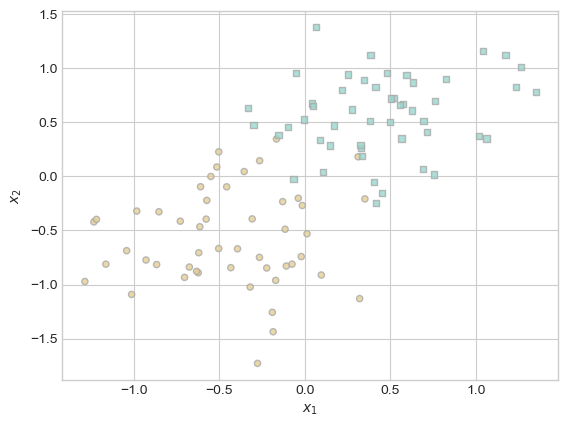

In [3]:
import torch 
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    # X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    X = X - X.mean(dim = 0, keepdim = True)
    return X, y


def plot_classification_data(X, y, ax):
    assert X.shape[1] == 2, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = classification_data(n_points = 100, noise = 0.4)
plot_classification_data(X, y, ax)

The <code>rbf_kernel</code> function below computes the Radial Basis Functionkernel — a popular way to measure similarity between data points. It takes two sets of vectors, $X_1$ and $X_2$, and returns a matrix where each entry represents how similar a point in $X_1$ is to a point in $X_2$. It does this by computing the squared Euclidean distances between the points (via torch.cdist), scaling those distances by gamma, and applying the exponential function. The result is a kernel matrix where closer points have values near 1 and more distant points have values near 0.

In [4]:
def rbf_kernel(X_1, X_2, gamma):
    return torch.exp(-gamma*torch.cdist(X_1, X_2)**2)

Below, I have ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍code that specifies  ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍500,000 ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍epochs ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍gradient ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍descent ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍learning ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍rate ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍
$10^{-4}$. ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍The ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍parameter <code>gamma</code>  ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍is ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍keyword ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍passed ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍<code>rbf_kernel</code>  ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍controls ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍bandwidth as it is a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍hyperparameter ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍can ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍be ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍tuned ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍in ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍cross-validation.

In [5]:
KR = KernelLogisticRegression(rbf_kernel, lam = 0.1, gamma = 1)
KR.fit(X, y, epochs = 500000, lr = 0.0001)

Epoch 0: Loss = 0.6931
Epoch 100: Loss = 0.6923
Epoch 200: Loss = 0.6914
Epoch 300: Loss = 0.6906
Epoch 400: Loss = 0.6898
Epoch 500: Loss = 0.6890
Epoch 600: Loss = 0.6882
Epoch 700: Loss = 0.6874
Epoch 800: Loss = 0.6867
Epoch 900: Loss = 0.6860
Epoch 1000: Loss = 0.6853
Epoch 1100: Loss = 0.6846
Epoch 1200: Loss = 0.6839
Epoch 1300: Loss = 0.6833
Epoch 1400: Loss = 0.6827
Epoch 1500: Loss = 0.6820
Epoch 1600: Loss = 0.6814
Epoch 1700: Loss = 0.6808
Epoch 1800: Loss = 0.6803
Epoch 1900: Loss = 0.6797
Epoch 2000: Loss = 0.6791
Epoch 2100: Loss = 0.6786
Epoch 2200: Loss = 0.6781
Epoch 2300: Loss = 0.6776
Epoch 2400: Loss = 0.6770
Epoch 2500: Loss = 0.6766
Epoch 2600: Loss = 0.6761
Epoch 2700: Loss = 0.6756
Epoch 2800: Loss = 0.6751
Epoch 2900: Loss = 0.6747
Epoch 3000: Loss = 0.6742
Epoch 3100: Loss = 0.6738
Epoch 3200: Loss = 0.6734
Epoch 3300: Loss = 0.6730
Epoch 3400: Loss = 0.6726
Epoch 3500: Loss = 0.6722
Epoch 3600: Loss = 0.6718
Epoch 3700: Loss = 0.6714
Epoch 3800: Loss = 0.671

Inspecting ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍weight ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍vector <code>KR.a</code> ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍shows ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍that ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍most ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍entries ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍are ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍very ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍close ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍to ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍zero.

In [6]:
(1.0*(KR.a > 0.001)).mean()

tensor(0.0800)

The ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍code ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍block ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍below ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍plots ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍scores ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍along ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍with ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data, ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍will ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍highlight ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍pieces ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍which ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍have ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍weights ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍distinguishable ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍from ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍0.

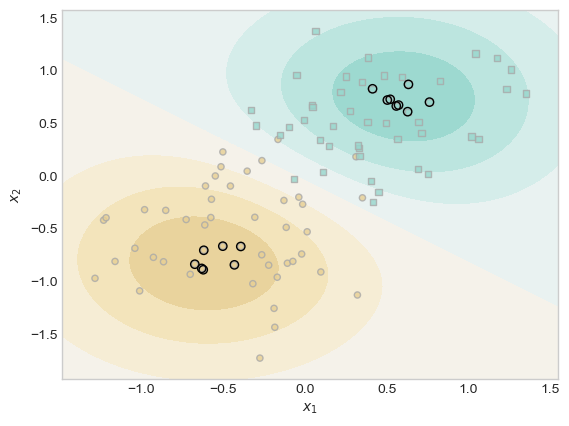

In [7]:
ix = torch.abs(KR.a) > 0.001

x1 = torch.linspace(X[:,0].min() - 0.2, X[:,0].max() + 0.2, 101)
x2 = torch.linspace(X[:,1].min() - 0.2, X[:,1].max() + 0.2, 101)

X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

x1 = X1.ravel()
x2 = X2.ravel()

X_ = torch.stack((x1, x2), dim = 1)

preds = KR.score(X_)
preds = 1.0*torch.reshape(preds, X1.size())

fig, ax = plt.subplots(1, 1)
ax.contourf(X1, X2, preds, origin = "lower", cmap = "BrBG", 
vmin = 2*preds.min() - preds.max(), vmax = 2*preds.max() - preds.min()
)
plot_classification_data(X, y, ax)
plt.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")
# ax.scatter(X[ix, 0],X[ix, 1], facecolors = "none", edgecolors = "black")

Epoch 0: Loss = 0.6892
Epoch 100: Loss = 0.6423
Epoch 200: Loss = 0.6359
Epoch 300: Loss = 0.6335
Epoch 400: Loss = 0.6322
Epoch 500: Loss = 0.6307
Epoch 600: Loss = 0.6300
Epoch 700: Loss = 0.6291
Epoch 800: Loss = 0.6290
Epoch 900: Loss = 0.6284
Epoch 0: Loss = 12.8850
Epoch 100: Loss = 1425.3674
Epoch 200: Loss = 2660.0278
Epoch 300: Loss = 3883.7214
Epoch 400: Loss = 5105.1763
Epoch 500: Loss = 6324.9033
Epoch 600: Loss = 7492.2520
Epoch 700: Loss = 7732.1611
Epoch 800: Loss = 7286.4023
Epoch 900: Loss = 6585.9546


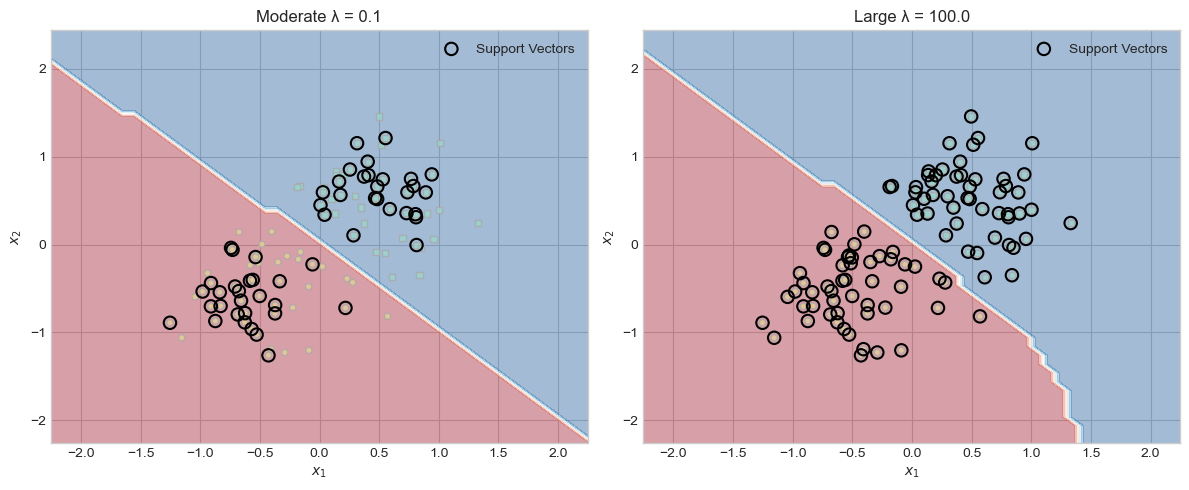

/var/folders/jj/kkhsq80d2pv7cj0ph5cb4rs40000gn/T/ipykernel_40986/433974894.py:45: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0].stem(KR_mod.a.detach().numpy(), use_line_collection=True)
/var/folders/jj/kkhsq80d2pv7cj0ph5cb4rs40000gn/T/ipykernel_40986/433974894.py:47: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[1].stem(KR_large.a.detach().numpy(), use_line_collection=True)


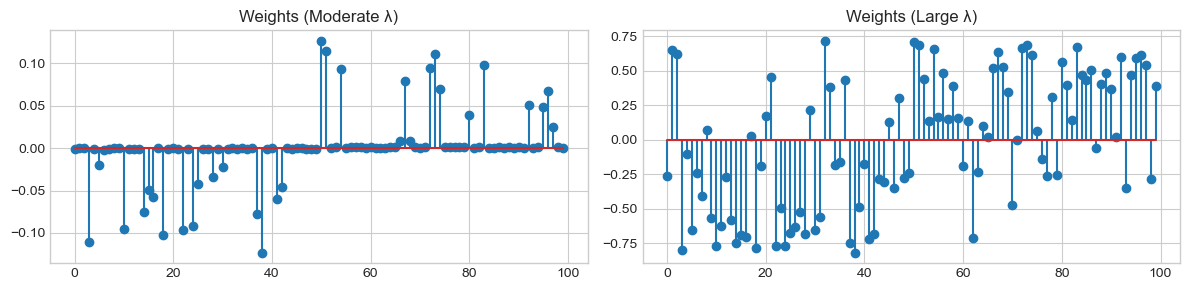

In [13]:
import numpy as np

def plot_decision_boundary(model, X, y, title="", ax=None):
    h = 0.1
    x_min, x_max = X[:, 0].min().item() - 1, X[:, 0].max().item() + 1
    y_min, y_max = X[:, 1].min().item() - 1, X[:, 1].max().item() + 1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h),
                            torch.arange(y_min, y_max, h), indexing="xy")
    grid = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1)
    Z = model.predict(grid).reshape(xx.shape)

    if ax is None:
        fig, ax = plt.subplots()
    ax.contourf(xx.numpy(), yy.numpy(), Z.numpy(), alpha=0.4, cmap="RdBu")
    plot_classification_data(X, y, ax)
    
    # Highlight points with non-zero weights (support vectors)
    nonzero = model.a.abs() > 1e-3
    ax.scatter(X[nonzero, 0], X[nonzero, 1], s=80, edgecolors='black',
               facecolors='none', linewidths=1.5, label='Support Vectors')

    ax.set_title(title)
    ax.legend()

# Recreate training data
X, y = classification_data(n_points=100, noise=0.4)

# Moderate λ
KR_mod = KernelLogisticRegression(rbf_kernel, lam=0.1, gamma=1)
KR_mod.fit(X, y, epochs=1000, lr=0.01)

# Large λ
KR_large = KernelLogisticRegression(rbf_kernel, lam=100.0, gamma=1)
KR_large.fit(X, y, epochs=1000, lr=0.01)

# Plot decision boundaries
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundary(KR_mod, X, y, title="Moderate λ = 0.1", ax=axes[0])
plot_decision_boundary(KR_large, X, y, title="Large λ = 100.0", ax=axes[1])
plt.tight_layout()
plt.show()

# Plot distribution of weights a
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
ax[0].stem(KR_mod.a.detach().numpy(), use_line_collection=True)
ax[0].set_title("Weights (Moderate λ)")
ax[1].stem(KR_large.a.detach().numpy(), use_line_collection=True)
ax[1].set_title("Weights (Large λ)")
plt.tight_layout()
plt.show()